In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# This project aims on converting one domain 256x256 RGB image to the other domain 256x256 RGB image.

# reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#            https://github.com/aladdinpersson/Machine-Learning-Collection
#            https://github.com/yunjey/pytorch-tutorial



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

pathOfData = '/content/drive/My Drive/research/pytorch-CycleGAN-and-pix2pix/datasets/img256'

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-rff9k6c_
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-rff9k6c_
     |████████████████████████████████| 37.1 MB 49 kB/s 
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=100681 sha256=5507514e1d84d92770ac956e82b8613c937b548644508263d30dd0d6af2c9853
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8k5sa8r/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class DirtyCleanDataset(Dataset):
    def __init__(self, root_dirty, root_clean, transform = None):
        self.root_dirty = root_dirty
        self.root_clean = root_clean
        self.transform = transform
        
        self.dirty_images = os.listdir(root_dirty)
        self.clean_images = os.listdir(root_clean)
        self.length_dataset = max(len(self.dirty_images),len(self.clean_images))
        self.clean_len = len(self.clean_images)
        self.dirty_len = len(self.dirty_images)
        
    def __len__(self):
        return self.length_dataset
    
    def __getitem__(self, index):
        dimage = self.dirty_images[index % self.dirty_len]
        cimage = self.clean_images[index % self.clean_len]
        
        dpath = os.path.join(self.root_dirty, dimage)
        cpath = os.path.join(self.root_clean, cimage)
        
        dimage = np.array(Image.open(dpath).convert("RGB"))
        cimage = np.array(Image.open(cpath).convert("RGB"))
        
        if self.transform:
            augmentations = self.transform(image = dimage, image0 = cimage)
            dimage = augmentations["image"]
            cimage = augmentations["image0"]
            
        return dimage, cimage


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


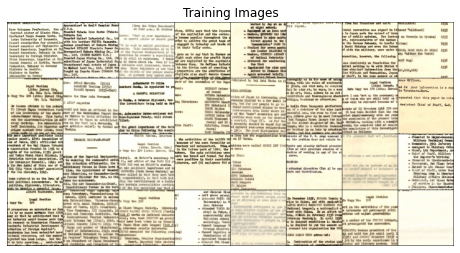

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.utils as vutils

dataroot = '/content/drive/My Drive/research/color'

image_size = 256
batch_size = 32
workers = 2

trans = A.Compose(
    [
        A.Resize(width = image_size, height = 256),
        A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value = 255),
        ToTensorV2(),
    ],
    additional_targets={"image0":"image"}
)

dataset = DirtyCleanDataset(root_dirty = dataroot+'/trainB', root_clean = dataroot+'/trainA',transform=trans)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True, num_workers = workers)

import matplotlib.pyplot as plt

real_batch = next(iter(dataloader))
# clean image
#plt.imshow(np.transpose(real_batch[1][30].cpu(),(1,2,0)))
# dirty image
#plt.imshow(np.transpose(real_batch[0][30].cpu(),(1,2,0)))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cpu()[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
real_batch[0][9].shape

torch.Size([3, 256, 256])

In [ ]:
# Build the model

import torch.nn as nn

loop = 5

class Discriminator(nn.Module):
    def __init__(self, input_channels, features_d):
        super(Discriminator,self).__init__()
        modules = []
        modules.append(nn.Conv2d(input_channels, features_d, kernel_size = 4, stride = 2, padding = 1))
        modules.append(nn.LeakyReLU(0.2))
        for i in range(loop):
            modules.append(self._conv(features_d * (2**i), features_d * (2**(i+1)),4,2,1))
        modules.append(nn.Conv2d(features_d * (2**loop), 1, kernel_size = 4, stride = 2, padding = 0))
        modules.append(nn.Sigmoid())
        self.disc = nn.Sequential(*modules)
    
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            #nn.ReLU(),
            #nn.LeakyReLU(0.2)
            )
    
    def forward(self, x):
        return self.disc(x)
    
    
class Generator(nn.Module):
    def __init__(self, input_channels, features_g):
        super(Generator, self).__init__()
        modules = []
        modules.append(self._dconv(input_channels,features_g,4,2,1))
        temp = features_g
        for i in range(loop):
            #modules.append(self._dconv(int(input_channels / (2**i)), int(features_g / (2**(i+1))),4,2,1))
            modules.append(self._dconv(temp, temp*2,4,2,1))
            temp = temp * 2
        for i in range(loop):
            #modules.append(self._uconv(input_channels * (2**i), features_g * (2**(i+1)),4,2,1))
            modules.append(self._uconv(int(temp), int(temp / 2),4,2,1))
            temp = temp/2
        modules.append(self._uconv(int(temp), input_channels,4,2,1))
        self.gen = nn.Sequential(*modules) 

        
    def _dconv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            #nn.LeakyReLU(0.2)
        )
    def _uconv(self, in_channel, out_channel, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            #nn.LeakyReLU(0.2)
            )
    
    def forward(self,x):
        return self.gen(x)


# as for DCGAN    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            m.init.normal_(m.weight.data, 0.0, 0.02)
            
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
def test():
    N, in_channels, H, W = 8, 3, 256, 256
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    #print(disc(x).shape)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(in_channels, 8)
    z = torch.randn((N, in_channels, H, W))
    #print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


test()

In [ ]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
netG = Generator(input_channels = 3, features_g = 52).to(device)
netG.apply(weights_init)
summary(netG,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 52, 128, 128]           2,496
       BatchNorm2d-2         [-1, 52, 128, 128]             104
            Conv2d-3          [-1, 104, 64, 64]          86,528
       BatchNorm2d-4          [-1, 104, 64, 64]             208
            Conv2d-5          [-1, 208, 32, 32]         346,112
       BatchNorm2d-6          [-1, 208, 32, 32]             416
            Conv2d-7          [-1, 416, 16, 16]       1,384,448
       BatchNorm2d-8          [-1, 416, 16, 16]             832
            Conv2d-9            [-1, 832, 8, 8]       5,537,792
      BatchNorm2d-10            [-1, 832, 8, 8]           1,664
           Conv2d-11           [-1, 1664, 4, 4]      22,151,168
      BatchNorm2d-12           [-1, 1664, 4, 4]           3,328
  ConvTranspose2d-13            [-1, 832, 8, 8]      22,151,168
      BatchNorm2d-14            [-1, 83

In [ ]:
netD = Discriminator(input_channels = 3, features_d = 52).to(device)
netD.apply(weights_init)
summary(netD,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 52, 128, 128]           2,548
         LeakyReLU-2         [-1, 52, 128, 128]               0
            Conv2d-3          [-1, 104, 64, 64]          86,528
       BatchNorm2d-4          [-1, 104, 64, 64]             208
            Conv2d-5          [-1, 208, 32, 32]         346,112
       BatchNorm2d-6          [-1, 208, 32, 32]             416
            Conv2d-7          [-1, 416, 16, 16]       1,384,448
       BatchNorm2d-8          [-1, 416, 16, 16]             832
            Conv2d-9            [-1, 832, 8, 8]       5,537,792
      BatchNorm2d-10            [-1, 832, 8, 8]           1,664
           Conv2d-11           [-1, 1664, 4, 4]      22,151,168
      BatchNorm2d-12           [-1, 1664, 4, 4]           3,328
           Conv2d-13              [-1, 1, 1, 1]          26,625
          Sigmoid-14              [-1, 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


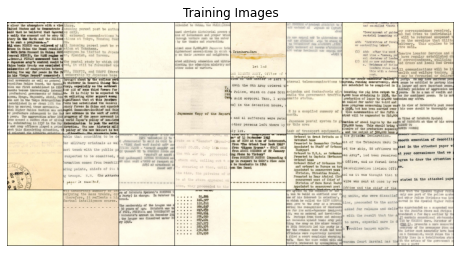

In [ ]:
# read test image

Test = DirtyCleanDataset(root_dirty = dataroot+'/testB', root_clean = dataroot+'/testA',transform=trans)

Testloader = torch.utils.data.DataLoader(Test, batch_size=32, shuffle = True, num_workers = workers)

test_batch = next(iter(Testloader))


plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].cpu(), padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Train the model

from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Learning_rate = 1e-3
Channels_img = 3
Features_dis = 64
Feature_gen = 64
Num_epochs = 100
beta1 = 0.5

opt_netG = optim.Adam(netG.parameters(), lr = Learning_rate, betas = (beta1, 0.999))
opt_netD = optim.Adam(netD.parameters(), lr = Learning_rate, betas = (beta1, 0.999))

criterion = nn.BCEWithLogitsLoss()

writer_dirty = SummaryWriter(f"/content/drive/My Drive/practice/GAN/dirty")
writer_clean = SummaryWriter(f"/content/drive/My Drive/practice/GAN/clean")

G_losses = []
D_losses = []
img_list = []
iters = 0

print("Starting Train: ...")


for epoch in range(Num_epochs):
    for batch_idx, (dirty,clean) in enumerate(dataloader, 0):
        #Train Discriminator: maximize log(D(x)) + log(1-D(G(z)))
        netD.zero_grad()
        clean = clean.to(device)
        dirty = dirty.to(device)
        dirty_clean = netG(dirty)
        
        dis_clean = netD(clean).reshape(-1)
        loss_dis_clean = criterion(dis_clean, torch.ones_like(dis_clean))
        dis_dirty = netD(dirty_clean.detach()).reshape(-1)
        loss_dis_dirty = criterion(dis_dirty, torch.zeros_like(dis_dirty))
        loss_dis = (loss_dis_clean + loss_dis_dirty) / 2
        loss_dis.backward()
        opt_netD.step()
        
        #Train Generator: minimum log(1-D(G(z))) => maximize log(D(G(z)))
        netG.zero_grad()
        gen_clean = netG(dirty).reshape(-1)
        loss_gen = criterion(gen_clean, torch.ones_like(gen_clean))
        loss_gen.backward()
        opt_netG.step() 
        
        if batch_idx % 1 == 0:
            print(f"Epoch: [{epoch}/{Num_epochs}],  Batch: [{batch_idx}/{len(dataloader)}],  Loss_D: {loss_dis:.4f},  Loss_G: {loss_gen:.4f}")
            G_losses.append(loss_gen)
            D_losses.append(loss_dis)

            with torch.no_grad():
                fixedDirty = test_batch[0].to(device)
                dir2clean = netG(fixedDirty)
                
                img_dirty = torchvision.utils.make_grid(fixedDirty,normalize=True)
                img_clean = torchvision.utils.make_grid(dir2clean,normalize=True)
                #plt.imshow(np.transpose(img_clean.cpu(),(1,2,0)))
                writer_dirty.add_image("Dirty", img_dirty, global_step = iters) 
                writer_clean.add_image("Clean", img_clean, global_step = iters)
                
                
        iters += 1


Starting Train: ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0/100],  Batch: [0/26],  Loss_D: 0.7349,  Loss_G: 0.8018
Epoch: [0/100],  Batch: [1/26],  Loss_D: 0.6605,  Loss_G: 0.7921
Epoch: [0/100],  Batch: [2/26],  Loss_D: 0.7432,  Loss_G: 0.7688
Epoch: [0/100],  Batch: [3/26],  Loss_D: 0.6845,  Loss_G: 0.7402
Epoch: [0/100],  Batch: [4/26],  Loss_D: 0.6657,  Loss_G: 0.7286
Epoch: [0/100],  Batch: [5/26],  Loss_D: 0.6022,  Loss_G: 0.7153
Epoch: [0/100],  Batch: [6/26],  Loss_D: 0.5420,  Loss_G: 0.7105
Epoch: [0/100],  Batch: [7/26],  Loss_D: 0.5619,  Loss_G: 0.7063
Epoch: [0/100],  Batch: [8/26],  Loss_D: 0.5041,  Loss_G: 0.7030
Epoch: [0/100],  Batch: [9/26],  Loss_D: 0.5032,  Loss_G: 0.7001
Epoch: [0/100],  Batch: [10/26],  Loss_D: 0.5091,  Loss_G: 0.6986
Epoch: [0/100],  Batch: [11/26],  Loss_D: 0.5088,  Loss_G: 0.6971
Epoch: [0/100],  Batch: [12/26],  Loss_D: 0.5032,  Loss_G: 0.6957
Epoch: [0/100],  Batch: [13/26],  Loss_D: 0.5032,  Loss_G: 0.6943
Epoch: [0/100],  Batch: [14/26],  Loss_D: 0.5032,  Loss_G: 0.6940
Epoch: [0/100],  Bat

In [ ]:
torch.save(netD.state_dict(), './Discriminator.pth')
torch.save(netG.state_dict(), './Generator.pth')

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/content/drive/MyDrive/practice/GAN/clean

In [ ]:
!tensorboard --logdir=/workspace/practice/GAN/dirty